# 📸 At tour of Rejax: Vectorizable RL Algorithms in Jax

`Rejax` is a library of reinforcement learning algorithms which you can `jax.jit` and `jax.vmap`. In this notebook, I want to show you the its key features:

- 🏃‍♀️ [Set up](#setup), [train](#training) and [evaluate](#evaluation) RL agents
- 🔙 Use [custom callbacks](#callbacks) to define how training curves are generated, log data to wandb and more
- 💫 [Vmap](#vmapping) the train function to train multiple agents in parallel
- 🎨 [Customize](#customizing) existing algorithms by overwriting their methods
<br><br>

<a href="https://colab.research.google.com/github/kerajli/rejax/blob/master/examples/rejax_tour.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a> &nbsp; and make sure you set the runtime to GPU!

In [1]:
import jax
import shutup
shutup.please()

## 🔨 Setting up the training configuration <a name="setup"></a>

1. Each algorithm is represented as a class that extends `flax.PyTreeNode`.
2. `get_algo` is a convinient function to access algorithms easily.
3. `algo_cls.create` creates a frozen instance of the algorithm, and populates it with default values.

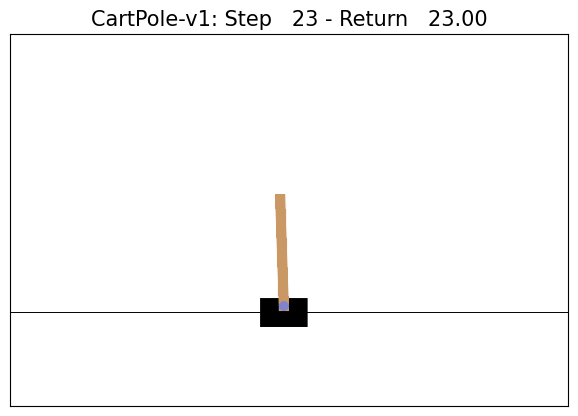

: 

In [3]:
import gymnax
from gymnax.visualize import Visualizer
import jax.numpy as jnp

rng = jax.random.PRNGKey(0)
env, env_params = gymnax.make("CartPole-v1")

state_seq, reward_seq = [], []
rng, rng_reset = jax.random.split(rng)
obs, env_state = env.reset(rng_reset, env_params)
while True:
    state_seq.append(env_state)
    rng, rng_act, rng_step = jax.random.split(rng, 3)
    action = env.action_space(env_params).sample(rng_act)
    next_obs, next_env_state, reward, done, info = env.step(
        rng_step, env_state, action, env_params
    )
    reward_seq.append(reward)
    if done:
        break
    else:
        obs = next_obs
        env_state = next_env_state

cum_rewards = jnp.cumsum(jnp.array(reward_seq))
vis = Visualizer(env, env_params, state_seq, cum_rewards)
vis.animate("anim.gif")

In [2]:
from rejax import get_algo

env_str = "brax/ant"  # @param ["CartPole-v1", "Acrobot-v1", "Pendulum-v1"]
algo_str = "ppo"  # @param ["ppo", "dqn", "sac", "td3"]

# We make some changes to the default hyperparameters to get better plots.
# All algorithms should work reasonably well on CartPole-v1 and Acrobot-1.
CONFIGS = {
    "sac": {"target_entropy_ratio": 0.7, "num_envs": 10, "num_epochs": 5},
    "ppo": {"total_timesteps": 3e5},
    "dqn": {},
    "td3": {"total_timesteps": 5e4, "normalize_observations": True},
}

algo_cls = get_algo(algo_str)
algo = algo_cls.create(env=env_str, learning_rate=0.0003, **CONFIGS.get(algo_str, {}))

2024-10-15 23:37:09.020847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 23:37:09.031507: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 23:37:09.034717: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 23:37:09.632546: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
state_seq, reward_seq = [], []
rng = jax.random.PRNGKey(42)
env = algo.env
env_params = algo.env_params
obs, env_state = env.reset(rng)

while True:
    state_seq.append(env_state.pipeline_state)
    rng, rng_act, rng_step = jax.random.split(rng, 3)
    action = env.action_space(env_params).sample(rng_act)
    next_obs, next_env_state, reward, done, info = env.step(
        rng_step, env_state, action, env_params
    )
    reward_seq.append(reward)
    if done:
        break
    else:
        obs = next_obs
        env_state = next_env_state

In [26]:
from PIL import Image

imgs = algo.env.render(state_seq)
pics = [Image.fromarray(img) for img in imgs]        
pics[0].save(
    "brax.gif",
    #format="mp4",
    save_all=True,
    optimize=False,
    append_images=pics[1:],
    duration=1,
    loop=0,
)

: 

Let's look at the algorithm instance we have created:

In [3]:
algo.config

{'env': <gymnax.environments.classic_control.cartpole.CartPole at 0x7cfff01a7700>,
 'env_params': {'max_steps_in_episode': 500,
  'gravity': 9.8,
  'masscart': 1.0,
  'masspole': 0.1,
  'total_mass': 1.1,
  'length': 0.5,
  'polemass_length': 0.05,
  'force_mag': 10.0,
  'tau': 0.02,
  'theta_threshold_radians': 0.20943951023931953,
  'x_threshold': 2.4},
 'eval_callback': <function rejax.algos.algorithm.Algorithm.create.<locals>.eval_callback(algo, ts, rng)>,
 'eval_freq': 4096,
 'skip_initial_evaluation': False,
 'total_timesteps': 131072,
 'learning_rate': 0.0003,
 'gamma': 0.99,
 'max_grad_norm': inf,
 'normalize_observations': False,
 'target_update_freq': 1,
 'polyak': 0.99,
 'num_envs': 1,
 'buffer_size': 131072,
 'fill_buffer': 2048,
 'batch_size': 256,
 'eps_start': 1.0,
 'eps_end': 0.05,
 'exploration_fraction': 0.1,
 'agent': {'hidden_layer_sizes': (64, 64),
  'activation': <PjitFunction>,
  'action_dim': 2,
  'parent': None,
  'name': None},
 'num_epochs': 1,
 'ddqn': True}

As you can see we have a lot of hyperparemeters and variables we can tune. You are free to modify these after the creation:

In [4]:
algo = algo.replace(gamma=0.995)
print(f"New gamma: {algo.gamma}")

New gamma: 0.995


**A few words about configs**

1. In `rejax`, algorithms extend `flax.struct.PyTreeNode`. This allows to jit and vmap over individual parameters while keeping others fixed. For example, you are free to vmap over `learning_rate`, but not over `total_timesteps`.

3. You are free to replace the config you pass to the training algorithm by any object that has the same (or necessary) attributes.

## 🏃‍♀️ Training the agent <a name="training"></a>

In [5]:
import jax
import time

# Set training seed and jit train function
rng = jax.random.PRNGKey(0)
train_fn = jax.jit(algo.train)

print("Starting to train")

# Train!
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = algo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

Starting to train
Finished training in 26.4151 seconds (4962.02 steps/second).


Whoa, that was pretty quick! Let's break down what just happened.
1. We jit `algo.train` to allow for fast execution 🚀
2. `algo.train` created an initial `train_state`, which holds information about the current state of the algorithm such as the current environment step, replay buffer contents, network parameters and more.
3. The `train_state` is transformed by the algorithm over the course of training. The final value of the `train_state` is returned, including the final network parameters.
4. Additionally, the returned `evaluation` value is a tuple of episode lengths and episodic returns. We take a look at how to customize this value later.

Let's look at how well training worked by plotting the learning curve!

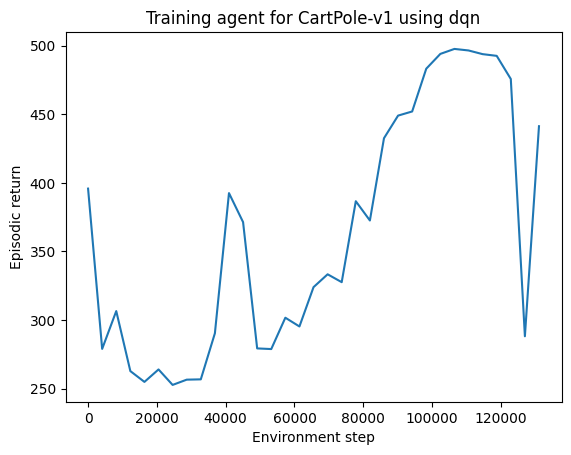

In [6]:
from matplotlib import pyplot as plt

episode_lengths, episode_returns = evaluation
mean_return = episode_returns.mean(axis=1)

plt.plot(jax.numpy.linspace(0, algo.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training agent for {env_str} using {algo_str}")
plt.show()

We should also take a look at the `train_state`, to see what the algorithm produced.

In [7]:
jax.tree_map(lambda x: x.shape, train_state).__dict__

{'rng': (2,),
 'env_state': EnvState(time=(1,), x=(1,), x_dot=(1,), theta=(1,), theta_dot=(1,)),
 'last_obs': (1, 4),
 'global_step': (),
 'last_done': (1,),
 'q_ts': TrainState(step=(), apply_fn=(), params={'params': {'Dense_0': {'bias': (64,), 'kernel': (4, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'Dense_2': {'bias': (2,), 'kernel': (64, 2)}}}, tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x7cfeddcf95a0>, update=<function chain.<locals>.update_fn at 0x7cfed07581f0>), opt_state=(ScaleByAdamState(count=(), mu={'params': {'Dense_0': {'bias': (64,), 'kernel': (4, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'Dense_2': {'bias': (2,), 'kernel': (64, 2)}}}, nu={'params': {'Dense_0': {'bias': (64,), 'kernel': (4, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'Dense_2': {'bias': (2,), 'kernel': (64, 2)}}}), EmptyState())),
 'q_target_params': {'params': {'Dense_0': {'bias': (64,), 'kernel': (4, 64)},
   'Dense_1': {'bias': (64,), 'k

In actor-critic algorithms, the `train_state` has an `actor_ts` as well as `critic_ts` which are instances of a `flax.training.train_state.TrainState`. These provide the network parameters of our final agent. Note that while also being a `flax.struct.PyTreeNode`, our `train_state` is not. Algorithms which use buffers also have a `replay_buffer` state.

## 🤖 Making and evaluating policies <a name="evaluation"></a>

As discussed above, algorithms return an agent's policy parameters in its train state. We can extract a policy of the type `Callable[[chex.Array, chex.PRNGKey], chex.Array]` which maps `(obs, rng) -> action` like this:

In [8]:
# Get policy and jit it
policy = algo.make_act(train_state)
policy = jax.jit(policy)

Let's evaluate the policy! For demonstration purposes here is a full rollout like you would do with gym:

In [9]:
# For demonstration purposes, we do a manual rollout of the policy
import gymnax

rng = jax.random.PRNGKey(0)
env, params = gymnax.make(env_str)
step = jax.jit(env.step)

obs, state = env.reset(rng, params)
episode_return = 0
done = False

while not done:
    rng, rng_action, rng_step = jax.random.split(rng, 3)
    action = policy(obs, rng_action)
    obs, state, reward, done, info = step(rng_step, state, action, params)
    episode_return += reward

print(f"Return achieved in one episode of {env_str}: {episode_return}")

Return achieved in one episode of CartPole-v1: 500.0


Alternatively, `rejax` offers fast parallel evaluation of policies under `rejax.evaluate`:

In [12]:
from rejax.evaluate import evaluate

num_seeds = 200  # @param {type:"slider", min:1, max:500, step:1}
max_steps = params.max_steps_in_episode

rng = jax.random.PRNGKey(0)

start = time.time()

# Evaluation time!
episode_lengths, episode_returns = evaluate(policy, rng, env, params, num_seeds, max_steps)

time_elapsed = time.time() - start

print(
    f"Evaluated {num_seeds} episodes "
    f"with a total of {jax.numpy.sum(episode_lengths)} environment steps "
    f"in {time_elapsed:g} seconds."
)

Evaluated 200 episodes with a total of 88980 environment steps in 0.891411 seconds.


[Text(0.5, 1.0, 'Episode return')]

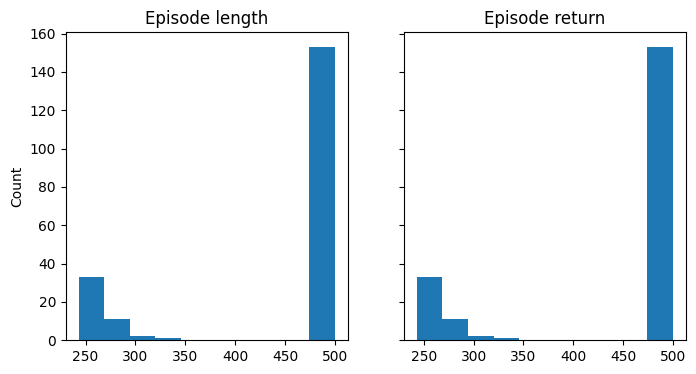

In [13]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2, sharey="row")

axes[0].hist(episode_lengths)
axes[0].set(title="Episode length", ylabel="Count")
axes[1].hist(episode_returns)
axes[1].set(title="Episode return")

# 😲 Advanced features

## 💫 Vmapping the train function <a name="vmapping"></a>

I want to fit an SAC agent for a discrete environment. However, the best `target_entropy_ratio` parameter varies extremely between environments. We can do the following
1. `jax.vmap` across the algorithm instance to run multiple values for the target entropy ratio in parallel
2. `jax.vmap` across the training seed to make sure our best run isn't a fluke

This can take a minute!

In [13]:
from rejax import SAC

num_seeds = 5  # @param {"type": "slider", "min": 1, "max": 10, "step": 1}
env_str = "CartPole-v1"  # @param ["CartPole-v1", "Acrobot-v1", "MountainCar-v0"]

def make_config(ter: float):
    return SAC.create(
        env=env_str,
        target_entropy_ratio=ter,
        num_envs=10,
        num_epochs=5,
        )

ters = jax.numpy.arange(0.1, 1, 0.1)
sac = jax.vmap(make_config)(ters)

rng = jax.random.PRNGKey(0)
rngs = jax.random.split(rng, num_seeds)

sac_train_fn = jax.jit(SAC.train)
sac_train_fn = jax.vmap(sac_train_fn, in_axes=(None, 0))  # Vmap across seeds
sac_train_fn = jax.vmap(sac_train_fn, in_axes=(0, None))  # Vmap across configs

start = time.time()
train_state, evaluation = sac_train_fn(sac, rngs)
time_elapsed = time.time() - start

sps = num_seeds * len(ters) * sac.total_timesteps / time_elapsed
print(
    f"Trained {num_seeds * len(ters)} agents "
    f"for {sac.total_timesteps} environment steps "
    f"in {time_elapsed // 60:.0f} minutes and {time_elapsed % 60:g} seconds."
)
print(f"That's {sps:g} steps / second!")

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Trained 45 agents for 100000 environment steps in 1 minutes and 1.39771 seconds.
That's 73292.6 steps / second!


The resulting evaluation now has shape `(num_values, num_train_seeds, num_evals, num_eval_seeds)`:

In [14]:
_, episode_returns = evaluation
print(f"shape of evaluation: {episode_returns.shape}")

shape of evaluation: (9, 5, 11, 200)


Text(0.5, 1.0, 'Different values for SAC target entropy ratio on CartPole-v1')

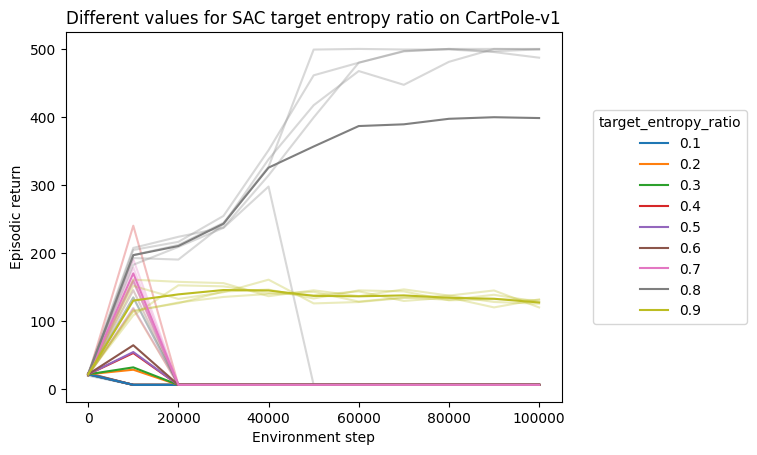

In [15]:
t = jax.numpy.linspace(0, sac.total_timesteps, episode_returns.shape[2])

# Plot all with alpha
for i, returns_for_val in enumerate(episode_returns):
    # take mean across evaluation seeds and transpose for plotting
    returns_for_val = returns_for_val.mean(axis=2).T
    plt.plot(t, returns_for_val, c=f"C{i}", alpha=0.3)

# Plot mean across training seeds
for i, returns_for_val in enumerate(episode_returns):
    returns_for_val = returns_for_val.mean(axis=(0, 2))
    plt.plot(t, returns_for_val, c=f"C{i}", label=f"{ters[i]:.1f}")

plt.legend(title="target_entropy_ratio", bbox_to_anchor=(1.05, 0.5), loc="center left")
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Different values for SAC target entropy ratio on {env_str}")

## 🔙 Using custom callbacks <a name="callbacks"></a>

If you were super alert, you might have noticed the `eval_callback` attribute of the training config. This can be any function of your choice! As long as it maps `(algo, train_state, rng) -> evaluation: chex.ArrayTree`. Two additional attributes control the evaluation behavior:
- `eval_freq`: the evaluating of `eval_callback` is called every `eval_freq` environment steps
- `skip_initial_evaluation`: if true, don't evaluate the initialized policy (but start after `eval_freq` steps instead).

The return value of `eval_callback` should be a PyTree of Jax arrays, so it can be aggregated over the course of training. To show how exactly this works out in practice, we can try to implement our custom callback which returns a dict with some information.

In [16]:
def dict_callback(algo, train_state, rng):
    policy = algo_cls.make_act(algo, train_state)
    l, r = evaluate(policy, rng, env, params, num_seeds, max_steps)
    return {
        "episode_lengths": l,
        "episode_returns": r,
        "global_step": train_state.global_step,
    }

In [17]:
rng = jax.random.PRNGKey(0)

# Replace eval_callback by new one!
algo = algo.replace(eval_callback=dict_callback)
_, evaluations = jax.jit(algo.train)(rng)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


In [18]:
print(f"total_timesteps: {algo.total_timesteps}")
print(f"eval_freq: {algo.eval_freq}")
print(f"Evaluation: {jax.tree_map(lambda x: x.shape, evaluations)}")

total_timesteps: 100000
eval_freq: 10000
Evaluation: {'episode_lengths': (11, 5), 'episode_returns': (11, 5), 'global_step': (11,)}


<ipython-input-18-3d651db76b58>:3: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  print(f"Evaluation: {jax.tree_map(lambda x: x.shape, evaluations)}")


As you can see, the entries in the evaluation dict have shape `(total_timesteps / eval_freq + 1, num_seeds)`. The `+1` comes from the fact that we evaluate the inital policy as well per default.

Since `train_fn` is the jitted `algo.train`, the `eval_callback` is jitted as well, so it must be pure. However, we can escape this via one of Jax's callbacks. For example, we can print the current performance of the agent over the course of training!

In [19]:
def print_callback(algo, train_state, rng):
    policy = algo_cls.make_act(algo, train_state)
    _, r = evaluate(policy, rng, env, params, num_seeds, max_steps)

    # Jax callback! This can be impure.
    jax.debug.print("step: {}, mean return: {}", train_state.global_step, r.mean())

    # Since we now print the result, we don't return it
    return ()

jax.jit(algo.replace(eval_callback=print_callback).train)(rng)
None  # Supress output

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


step: 0, mean return: 340.3999938964844
step: 10000, mean return: 245.40000915527344
step: 20000, mean return: 218.1999969482422
step: 30000, mean return: 464.3999938964844
step: 40000, mean return: 281.20001220703125
step: 50000, mean return: 500.0
step: 60000, mean return: 500.0
step: 70000, mean return: 451.6000061035156
step: 80000, mean return: 500.0
step: 90000, mean return: 500.0
step: 100000, mean return: 500.0


Feel free to use `jax.experimental.io_callback`, `jax.debug.callback` or `jax.pure_callback` for more finegrained control over callbacks. For example, I've included an example of how to log to wandb in the repositories `examples` folder!

## 🎨 Customize and extend existing algorithms to your liking <a name="customizing"></a>

The algorithms in `rejax` are stateless classes, meaning all of their methods are class methods. You are free to subclass and overwrite these methods! This can be very helpful when trying to modify or extend existing algorithms.

Let us replace the actor loss of PPO to create an instance of [Discovered Policy Optimization](https://arxiv.org/abs/2210.05639) [1].
In a nutshell, DPO replaces the surrogate objective of PPO with

$$
L_\text{actor} = \sum_{s, a} r A - f(r, A)
$$

where $A = A^{\pi_k}(s, a)$,  $r = \pi(a|s) / \pi_k(a|s)$ and

$$
f(r, A) =
\begin{cases}
\text{ReLU}((r - 1)A - \alpha \tanh((r - 1)A/\alpha)) & \text{if } A \geq 0, \\
\text{ReLU}(\log(r)A - \beta \tanh(\log(r)A/\beta)) & \text{if } A < 0.
\end{cases}
$$

For more detail, see: <br>Chris Lu, Jakub Grudzien Kuba, Alistair Letcher, Luke Metz, Christian Schroeder de Witt, & Jakob Foerster. (2022). Discovered Policy Optimisation.

We can easily replace `PPO.update_actor` by this new loss function, while keeping the rest of the algorithm as is.

In [20]:
from rejax import PPO

def dpo_drift(ratio, advantages, alpha=2.0, beta=0.6):
    """Calculate the drift term for DPO, which is part of the loss."""

    # The two drifts represent the cases for A < 0 (A >= 0) in the
    # formula for f
    drift1 = jax.nn.relu(
        (ratio - 1) * advantages
        - alpha * jax.numpy.tanh((ratio - 1) * advantages / alpha)
    )
    drift2 = jax.nn.relu(
        jax.numpy.log(ratio) * advantages
        - beta * jax.numpy.tanh(jax.numpy.log(ratio) * advantages / beta)
    )
    drift = jax.numpy.where(advantages >= 0, drift1, drift2)
    return drift

# Overwrite PPO to change actor update, modifying the loss function
class DPO(PPO):
    def update_actor(self, ts, batch):
        def actor_loss_fn(params):
            # self.actor is a flax model on which we call the apply function
            log_prob, entropy = self.actor.apply(
                params,
                batch.trajectories.obs,
                batch.trajectories.action,
                method="log_prob_entropy",
            )
            entropy = entropy.mean()

            # Calculate drift and finally actor loss as in DPO
            ratio = jax.numpy.exp(log_prob - batch.trajectories.log_prob)
            advantages = batch.advantages
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            drift = dpo_drift(ratio, advantages)
            pi_loss = -(ratio * advantages - drift).mean()

            return pi_loss - self.ent_coef * entropy

        grads = jax.grad(actor_loss_fn)(ts.actor_ts.params)
        return ts.replace(actor_ts=ts.actor_ts.apply_gradients(grads=grads))

Let's see if DPO can train an agent!

In [21]:
env_str = "Pendulum-v1"  # @param ["CartPole-v1", "Acrobot-v1", "Pendulum-v1"]

rng = jax.random.PRNGKey(0)
dpo_config = DPO.create(
    env=env_str,
    total_timesteps=3e5,
    learning_rate=0.001,
    num_epochs=10,
)
dpo_train_fn = jax.jit(DPO.train)
_, (_, returns) = dpo_train_fn(dpo_config, rng)

Text(0.5, 1.0, 'Discovered Policy Optimization on Pendulum-v1')

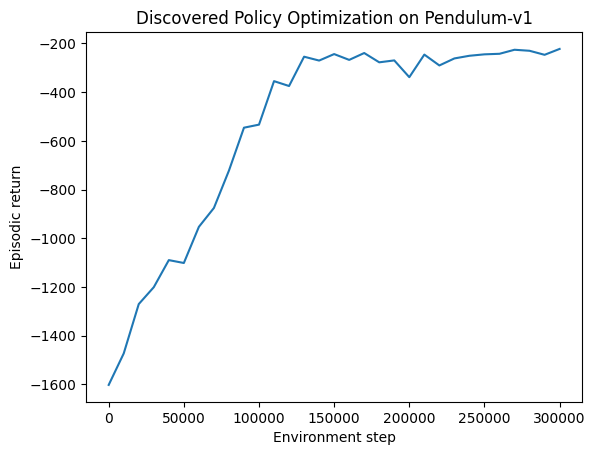

In [22]:
plt.plot(
    jax.numpy.linspace(0, dpo_config.total_timesteps, len(returns)),
    returns.mean(axis=1),
)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Discovered Policy Optimization on {env_str}")

Seems like it!

🤗 I hope this tour was instructive, let me know if I can help you using rejax in any way!